In [2]:
#Importing the necessary libraries
import platform
print("Python version:", platform.python_version())

import sys
import os

import tensorflow as tf
print("tensorflow version:",tf.__version__)

import numpy as np
print("numpy version:",np.__version__)

import cv2
print("cv2 version:",cv2.__version__)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
print("matplotlib version:",matplotlib.__version__)

import pandas as pd
print("pandas version:",pd.__version__)

from skimage.transform import resize

from tensorflow.keras import datasets, layers, models

Python version: 3.9.19
tensorflow version: 2.10.0
numpy version: 1.26.4
cv2 version: 4.9.0
matplotlib version: 3.8.4
pandas version: 2.2.1


In [3]:
# Check for GPU availability
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data Preparation

In [4]:
#Function to change the path format
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path


#Loading the training data for damage images
#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('./','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name',
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]


In [5]:
print(len(train_dmg))
train_dmg

4381


,image file name,component label file name,damage label file name,depth image file name,camera focal length in mm
0,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,43.375470
3,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,43.242723
5,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,20.921244
7,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,46.639972
11,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,53.623157
...,...,...,...,...,...
13941,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,51.725212
13942,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,53.422408
13945,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,41.561651
13949,./Tokaido_dataset\img_syn_raw/train/image_case...,./Tokaido_dataset\synthetic/train/labcmp/image...,./Tokaido_dataset\synthetic/train/labdmg/image...,./Tokaido_dataset\synthetic/train/depth/image_...,36.669088


image file name                         ./Tokaido_dataset\img_syn_raw/train/image_case...
component label file name               ./Tokaido_dataset\synthetic/train/labcmp/image...
damage label file name                  ./Tokaido_dataset\synthetic/train/labdmg/image...
depth image file name                   ./Tokaido_dataset\synthetic/train/depth/image_...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(1080, 1920, 3)
<class 'numpy.ndarray'>


C:\Users\REP_SIF_2\AppData\Local\Temp\ipykernel_21872\731981023.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[3][0])


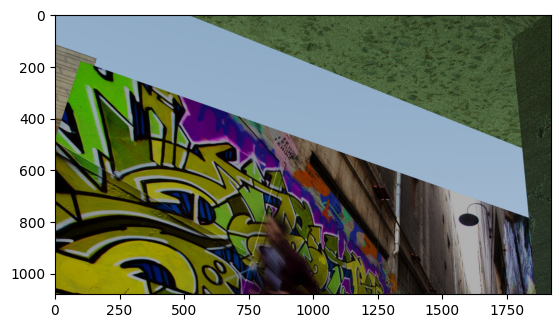

In [6]:
#Printing the training image

#image
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][0])
print(image.shape)
print(type(image))
plt.imshow(image)


image file name                         ./Tokaido_dataset\img_syn_raw/train/image_case...
component label file name               ./Tokaido_dataset\synthetic/train/labcmp/image...
damage label file name                  ./Tokaido_dataset\synthetic/train/labdmg/image...
depth image file name                   ./Tokaido_dataset\synthetic/train/depth/image_...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(360, 640)
<class 'numpy.ndarray'>


C:\Users\REP_SIF_2\AppData\Local\Temp\ipykernel_21872\3998249144.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[3][2])#[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}


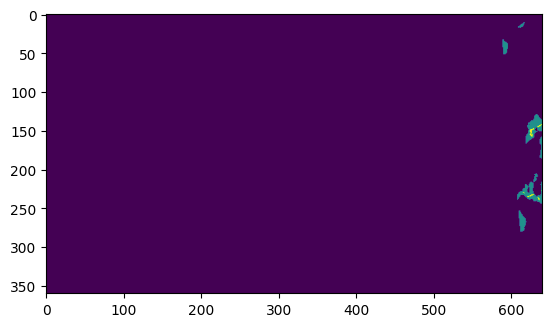

In [7]:
#label
#Printing the above image label
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][2])#[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}
print(image.shape)
print(type(image))
plt.imshow(image)

In [8]:
#Run for training on the damage images
train1 = train_dmg[:4000]
val1 = train_dmg[4000:]

image file name           ./Tokaido_dataset\images_puretex/im820_Concret...
damage label file name    ./Tokaido_dataset\synthetic_puretex/labdmg/im8...
Name: 0, dtype: object
(360, 640)
<class 'numpy.ndarray'>


C:\Users\REP_SIF_2\AppData\Local\Temp\ipykernel_21872\2104783165.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[0][1])


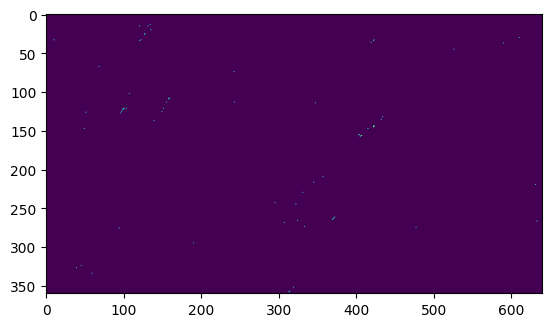

In [9]:
#Loading the training data from the pure_tex file

#Access the csv file containing the absolute directory paths to each file
path_ds = os.path.join('./','Tokaido_dataset') #put a path to the dataset
col_names = ['image file name', 'damage label file name']

ftrain = pd.read_csv(os.path.join(path_ds,'files_puretex_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))

train_tex = ftrain

#Printing the training image
print(ftrain.iloc[0])
image = mpimg.imread(ftrain.iloc[0][1])
print(image.shape)
print(type(image))
plt.imshow(image)

In [10]:
print(len(train_tex))
train_tex

2700


,image file name,damage label file name
0,./Tokaido_dataset\images_puretex/im820_Concret...,./Tokaido_dataset\synthetic_puretex/labdmg/im8...
1,./Tokaido_dataset\images_puretex/im418_Concret...,./Tokaido_dataset\synthetic_puretex/labdmg/im4...
2,./Tokaido_dataset\images_puretex/im704_Concret...,./Tokaido_dataset\synthetic_puretex/labdmg/im7...
3,./Tokaido_dataset\images_puretex/im2589_Concre...,./Tokaido_dataset\synthetic_puretex/labdmg/im2...
4,./Tokaido_dataset\images_puretex/im962_Concret...,./Tokaido_dataset\synthetic_puretex/labdmg/im9...
...,...,...
2695,./Tokaido_dataset\images_puretex/im763_Concret...,./Tokaido_dataset\synthetic_puretex/labdmg/im7...
2696,./Tokaido_dataset\images_puretex/im835_Concret...,./Tokaido_dataset\synthetic_puretex/labdmg/im8...
2697,./Tokaido_dataset\images_puretex/im1653_Concre...,./Tokaido_dataset\synthetic_puretex/labdmg/im1...
2698,./Tokaido_dataset\images_puretex/im2607_Concre...,./Tokaido_dataset\synthetic_puretex/labdmg/im2...


In [11]:
# Append the first 2300 rows from 'train_tex' to 'train1'
train1 = pd.concat([train1, train_tex[:2300]])

# Append the remaining rows from 'train_tex' to 'val1'
val1 = pd.concat([val1, train_tex[2300:]])

### Data Preprocessing

In [12]:
def get_label(file_path):
    #img = tf.io.read_file(file_path)
    #mask = file_path
    mask = np.squeeze(file_path, axis = 2)
    target_array = np.zeros((mask.shape[0],mask.shape[1],3))
    target_array[:,:,0]=np.where(mask == 1, 1, 0)
    target_array[:,:,1]=np.where(mask == 2, 1, 0)
    target_array[:,:,2]=np.where(mask == 3, 1, 0)

    return target_array

def show_img(image):
  #image = np.squeeze(image, axis = -1)
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

def show_label(label):
  fig, axes = plt.subplots(1, 3, figsize=(16, 112))
  y1 = label[:,:,0]
  y2 = label[:,:,1]
  y3 = label[:,:,2]
  plt.axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)

# Function to print the prediction images
def show_pred(y, threshold=0.5):
  # y = (y > threshold)
  fig, axes = plt.subplots(1, 3, figsize=(16, 112))
  y1 = y[:,:,0]
  y2 = y[:,:,1]
  y3 = y[:,:,2]
  plt.axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)


def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

def image_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  return img

def label_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  return img

In [13]:
def preprocess(x, y):
    def f(x, y):
        x = tf.io.read_file(x)
        y = tf.io.read_file(y)
        x = tf.io.decode_png(x, channels = 3)
        x = tf.image.resize_with_pad(x, 256, 256)
        x = tf.numpy_function(normalize, [x], [tf.float32])
        y = tf.io.decode_png(y, channels = 0)
        y = tf.numpy_function(get_label, [y], [tf.float32])
        y = tf.image.resize_with_pad(y, 256, 256)
        x = tf.numpy_function(image_augmentation, [x], [tf.float32])
        y = tf.numpy_function(label_augmentation, [y], [tf.float32])

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([256, 256, 3])
    masks.set_shape([256, 256, 3])

    return images, masks

In [14]:
# Extract image and mask file paths from the CSV file
train_image_paths = train1['image file name'].values
train_mask_paths = train1['damage label file name'].values

val_image_paths = val1['image file name'].values
val_mask_paths = val1['damage label file name'].values

In [15]:
# from sklearn.model_selection import train_test_split

# # Split the data into training and validation sets
# train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
#     image_paths, mask_paths, test_size=0.2, random_state=42
# )


In [16]:
# Create training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

# Apply the preprocess function to load and preprocess images and masks
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

# batch, and prefetch the datasets
train_batch_size = 1
val_batch_size = 1

train_dataset = train_dataset.batch(train_batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(val_batch_size).prefetch(tf.data.AUTOTUNE)

In [17]:
len(train_dataset)

6300

(256, 256, 3)
(256, 256, 3)


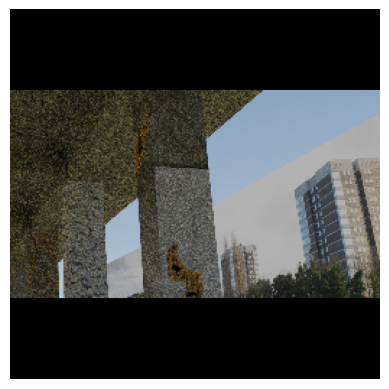

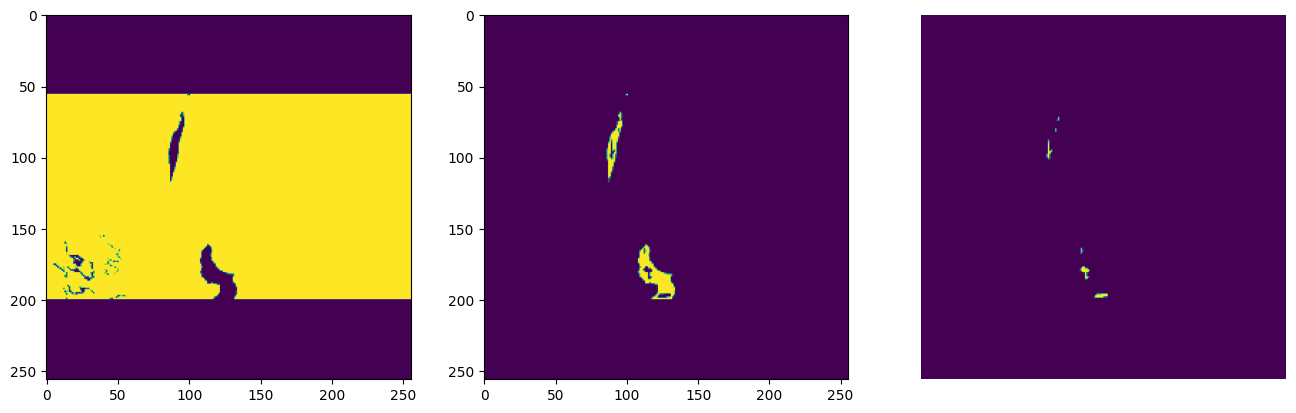

In [18]:
for batch in val_dataset:
        x, y = batch
        show_img(x[0])
        print(x[0].shape)
        show_label(y[0])
        print(y[0].shape)

        break

       

### Model

In [19]:
BUFFER_SIZE = 2000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
INPUT_SHAPE = [256, 256, 3]
OUTPUT_CHANNELS = 3

In [20]:
# class Downsample(tf.keras.Model):
#     def __init__(self, filters, size, apply_batchnorm=True):
#         super(Downsample, self).__init__()
#         self.apply_batchnorm = apply_batchnorm
#         # initializer = tf.random_normal_initializer(0., 0.02)
#         initializer = tf.initializers.HeNormal(seed=42)


#         self.conv1 = tf.keras.layers.Conv2D(filters,
#                                         (size, size),
#                                         strides=2,
#                                         padding='same',
#                                         kernel_initializer=initializer,
#                                         use_bias=False)
#         if self.apply_batchnorm:
#             self.batchnorm = tf.keras.layers.BatchNormalization()

#     def call(self, x, training):
#         x = self.conv1(x)
#         if self.apply_batchnorm:
#             x = self.batchnorm(x, training=training)
#         x = tf.nn.leaky_relu(x)
#         return x


# class Upsample(tf.keras.Model):
#     def __init__(self, filters, size, apply_dropout=False):
#         super(Upsample, self).__init__()
#         self.apply_dropout = apply_dropout
#         # initializer = tf.random_normal_initializer(0., 0.02)
#         initializer = tf.initializers.HeNormal(seed=42)


#         self.up_conv = tf.keras.layers.Conv2DTranspose(filters,
#                                                    (size, size),
#                                                    strides=2,
#                                                    padding='same',
#                                                    kernel_initializer=initializer,
#                                                    use_bias=False)
#         self.batchnorm = tf.keras.layers.BatchNormalization()
#         if self.apply_dropout:
#             self.dropout = tf.keras.layers.Dropout(0.5)

#     def call(self, x1, x2, training):
#         x = self.up_conv(x1)
#         x = self.batchnorm(x, training=training)
#         if self.apply_dropout:
#             x = self.dropout(x, training=training)
#         x = tf.nn.relu(x)
#         x = tf.concat([x, x2], axis=-1)
#         return x


# class Generator(tf.keras.Model):
#     def __init__(self):
#         super(Generator, self).__init__()
#         # initializer = tf.random_normal_initializer(0., 0.02)
#         initializer = tf.initializers.HeNormal(seed=42)

#         self.down1 = Downsample(64, 4, apply_batchnorm=False)
#         self.down2 = Downsample(128, 4)
#         self.down3 = Downsample(256, 4)
#         self.down4 = Downsample(512, 4)
#         self.down5 = Downsample(512, 4)
#         self.down6 = Downsample(512, 4)
#         self.down7 = Downsample(512, 4)
#         self.down8 = Downsample(512, 4)

#         self.up1 = Upsample(512, 4, apply_dropout=True)
#         self.up2 = Upsample(512, 4, apply_dropout=True)
#         self.up3 = Upsample(512, 4, apply_dropout=True)
#         self.up4 = Upsample(512, 4)
#         self.up5 = Upsample(256, 4)
#         self.up6 = Upsample(128, 4)
#         self.up7 = Upsample(64, 4)

#         self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
#                                                 (4, 4),
#                                                 strides=2,
#                                                 padding='same',
#                                                 kernel_initializer=initializer)

#     def call(self, x, training):
#         # x shape == (bs, 256, 256, 3)
#         x1 = self.down1(x, training=training) # (bs, 128, 128, 64)
#         x2 = self.down2(x1, training=training) # (bs, 64, 64, 128)
#         x3 = self.down3(x2, training=training) # (bs, 32, 32, 256)
#         x4 = self.down4(x3, training=training) # (bs, 16, 16, 512)
#         x5 = self.down5(x4, training=training) # (bs, 8, 8, 512)
#         x6 = self.down6(x5, training=training) # (bs, 4, 4, 512)
#         x7 = self.down7(x6, training=training) # (bs, 2, 2, 512)
#         x8 = self.down8(x7, training=training) # (bs, 1, 1, 512)

#         x9 = self.up1(x8, x7, training=training) # (bs, 2, 2, 1024)
#         x10 = self.up2(x9, x6, training=training) # (bs, 4, 4, 1024)
#         x11 = self.up3(x10, x5, training=training) # (bs, 8, 8, 1024)
#         x12 = self.up4(x11, x4, training=training) # (bs, 16, 16, 1024)
#         x13 = self.up5(x12, x3, training=training) # (bs, 32, 32, 512)
#         x14 = self.up6(x13, x2, training=training) # (bs, 64, 64, 256)
#         x15 = self.up7(x14, x1, training=training) # (bs, 128, 128, 128)

#         x16 = self.last(x15) # (bs, 256, 256, 3)
#         x16 = tf.keras.activations.sigmoid(x16)

#         return x16



"""
Utility functions for Unet3+ models
"""
import tensorflow as tf
import tensorflow.keras as k


def conv_block(x, kernels, kernel_size=(3, 3), strides=(1, 1), padding='same',
               is_bn=True, is_relu=True, n=2):
    """ Custom function for conv2d:
        Apply  3*3 convolutions with BN and relu.
    """
    for i in range(1, n + 1):
        x = k.layers.Conv2D(filters=kernels, kernel_size=kernel_size,
                            padding=padding, strides=strides,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                            kernel_initializer=k.initializers.he_normal(seed=5))(x)
        if is_bn:
            x = k.layers.BatchNormalization()(x)
        if is_relu:
            x = k.activations.relu(x)

    return x


def dot_product(seg, cls):
    b, h, w, n = k.backend.int_shape(seg)
    seg = tf.reshape(seg, [-1, h * w, n])
    final = tf.einsum("ijk,ik->ijk", seg, cls)
    final = tf.reshape(final, [-1, h, w, n])
    return final


"""
UNet3+ base model
"""
import tensorflow as tf
import tensorflow.keras as k

def unet3plus(input_shape, output_channels):
    """ UNet3+ base model """
    filters = [64, 128, 256, 512, 1024]

    input_layer = k.layers.Input(
        shape=input_shape,
        name="input_layer"
    )  # 320*320*3

    """ Encoder"""
    # block 1
    e1 = conv_block(input_layer, filters[0])  # 320*320*64

    # block 2
    e2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 160*160*64
    e2 = conv_block(e2, filters[1])  # 160*160*128

    # block 3
    e3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 80*80*128
    e3 = conv_block(e3, filters[2])  # 80*80*256

    # block 4
    e4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 40*40*256
    e4 = conv_block(e4, filters[3])  # 40*40*512

    # block 5
    # bottleneck layer
    e5 = k.layers.MaxPool2D(pool_size=(2, 2))(e4)  # 20*20*512
    e5 = conv_block(e5, filters[4])  # 20*20*1024

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4 """
    e1_d4 = k.layers.MaxPool2D(pool_size=(8, 8))(e1)  # 320*320*64  --> 40*40*64
    e1_d4 = conv_block(e1_d4, cat_channels, n=1)  # 320*320*64  --> 40*40*64

    e2_d4 = k.layers.MaxPool2D(pool_size=(4, 4))(e2)  # 160*160*128 --> 40*40*128
    e2_d4 = conv_block(e2_d4, cat_channels, n=1)  # 160*160*128 --> 40*40*64

    e3_d4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 80*80*256  --> 40*40*256
    e3_d4 = conv_block(e3_d4, cat_channels, n=1)  # 80*80*256  --> 40*40*64

    e4_d4 = conv_block(e4, cat_channels, n=1)  # 40*40*512  --> 40*40*64

    e5_d4 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(e5)  # 80*80*256  --> 40*40*256
    e5_d4 = conv_block(e5_d4, cat_channels, n=1)  # 20*20*1024  --> 20*20*64

    d4 = k.layers.concatenate([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, upsample_channels, n=1)  # 40*40*320  --> 40*40*320

    """ d3 """
    e1_d3 = k.layers.MaxPool2D(pool_size=(4, 4))(e1)  # 320*320*64 --> 80*80*64
    e1_d3 = conv_block(e1_d3, cat_channels, n=1)  # 80*80*64 --> 80*80*64

    e2_d3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 160*160*256 --> 80*80*256
    e2_d3 = conv_block(e2_d3, cat_channels, n=1)  # 80*80*256 --> 80*80*64

    e3_d3 = conv_block(e3, cat_channels, n=1)  # 80*80*512 --> 80*80*64

    e4_d3 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d4)  # 40*40*320 --> 80*80*320
    e4_d3 = conv_block(e4_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    e5_d3 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(e5)  # 20*20*320 --> 80*80*320
    e5_d3 = conv_block(e5_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    d3 = k.layers.concatenate([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3])
    d3 = conv_block(d3, upsample_channels, n=1)  # 80*80*320 --> 80*80*320

    """ d2 """
    e1_d2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 320*320*64 --> 160*160*64
    e1_d2 = conv_block(e1_d2, cat_channels, n=1)  # 160*160*64 --> 160*160*64

    e2_d2 = conv_block(e2, cat_channels, n=1)  # 160*160*256 --> 160*160*64

    d3_d2 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d3)  # 80*80*320 --> 160*160*320
    d3_d2 = conv_block(d3_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d4_d2 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d4)  # 40*40*320 --> 160*160*320
    d4_d2 = conv_block(d4_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    e5_d2 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(e5)  # 20*20*320 --> 160*160*320
    e5_d2 = conv_block(e5_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d2 = k.layers.concatenate([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, upsample_channels, n=1)  # 160*160*320 --> 160*160*320

    """ d1 """
    e1_d1 = conv_block(e1, cat_channels, n=1)  # 320*320*64 --> 320*320*64

    d2_d1 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d2)  # 160*160*320 --> 320*320*320
    d2_d1 = conv_block(d2_d1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d3_d1 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d3)  # 80*80*320 --> 320*320*320
    d3_d1 = conv_block(d3_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d4_d1 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(d4)  # 40*40*320 --> 320*320*320
    d4_d1 = conv_block(d4_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    e5_d1 = k.layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(e5)  # 20*20*320 --> 320*320*320
    e5_d1 = conv_block(e5_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d1 = k.layers.concatenate([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1, ])
    d1 = conv_block(d1, upsample_channels, n=1)  # 320*320*320 --> 320*320*320

    # last layer does not have batchnorm and relu
    d = conv_block(d1, output_channels, n=1, is_bn=False, is_relu=False)

    output = k.activations.sigmoid(d)

    return tf.keras.Model(inputs=input_layer, outputs=[output], name='UNet_3Plus')

In [21]:
INPUT_SHAPE = [256, 256, 3]
OUTPUT_CHANNELS = 3

generator = unet3plus(INPUT_SHAPE, OUTPUT_CHANNELS)
generator.summary()

Model: "UNet_3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                        

In [22]:
class DiscDownsample(tf.keras.Model):
    def __init__(self, filters, size, apply_batchnorm=True):
        super(DiscDownsample, self).__init__()
        self.apply_batchnorm = apply_batchnorm
        initializer = tf.random_normal_initializer(0., 0.02)
        # initializer = tf.initializers.HeNormal(seed=42)


        self.conv1 = tf.keras.layers.Conv2D(filters,
                                        (size, size),
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
        if self.apply_batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()

    def call(self, x, training):
        x = self.conv1(x)
        if self.apply_batchnorm:
            x = self.batchnorm(x, training=training)
        x = tf.nn.leaky_relu(x)
        return x

class Discriminator(tf.keras.Model):

    def __init__(self):
        super(Discriminator, self).__init__()
        initializer = tf.random_normal_initializer(0., 0.02)
        #initializer = tf.initializers.HeNormal(seed= 42)


        self.down1 = DiscDownsample(64, 4, False)
        self.down2 = DiscDownsample(128, 4)
        self.down3 = DiscDownsample(256, 4)

        self.convolution_layer = tf.keras.layers.Conv2D(1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid')  # Add a convolutional layer to adjust channels if necessary

    # we are zero padding here with 1 because we need our shape to
    # go from (batch_size, 32, 32, 256) to (batch_size, 31, 31, 512)
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512,
                                       (4, 4),
                                       strides=1,
                                       kernel_initializer=initializer,
                                       use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()

    # shape change from (batch_size, 31, 31, 512) to (batch_size, 30, 30, 1)
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1,
                                       (4, 4),
                                       strides=1,
                                       kernel_initializer=initializer)

    def call(self, inp, tar, training):
        # concatenating the input and the target
        x = tf.concat([inp, tar], axis=-1) # (bs, 256, 256, channels*2)
        x = self.down1(x, training=training) # (bs, 128, 128, 64)
        x = self.down2(x, training=training) # (bs, 64, 64, 128)
        x = self.down3(x, training=training) # (bs, 32, 32, 256)

        x = self.zero_pad1(x) # (bs, 34, 34, 256)
        x = self.conv(x)      # (bs, 31, 31, 512)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.zero_pad2(x) # (bs, 33, 33, 512)
        # don't add a sigmoid activation here since
        # the loss function expects raw logits.
        x = self.last(x)      # (bs, cen, 30, 1 )
        x = tf.image.resize(x, [256, 256])  # Upsample to target size

        x = self.convolution_layer(x)


        return x

In [23]:

discriminator = Discriminator()

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

In [25]:
checkpoint_dir = './checkpoint_new_unet3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
checkpoint_prefix


'./checkpoint_new_unet3\\ckpt'

### Inference

In [27]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  show_img(test_input[0])
  show_label(tar[0])
  show_pred(prediction[0])
  plt.show()

In [28]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

device = ""

for i in device_lib.list_local_devices():
  if i.name == '/device:GPU:0':
    device = '/device:GPU:0'
    break
  elif i.name == '/device:XLA_GPU:0':
    device = '/device:XLA_GPU:0'


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6831732365328984737
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 46342936320
locality {
  bus_id: 1
}
incarnation: 13263274595239803588
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


In [33]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

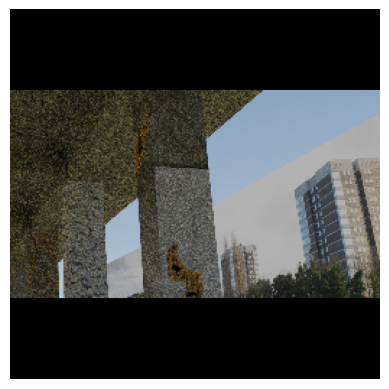

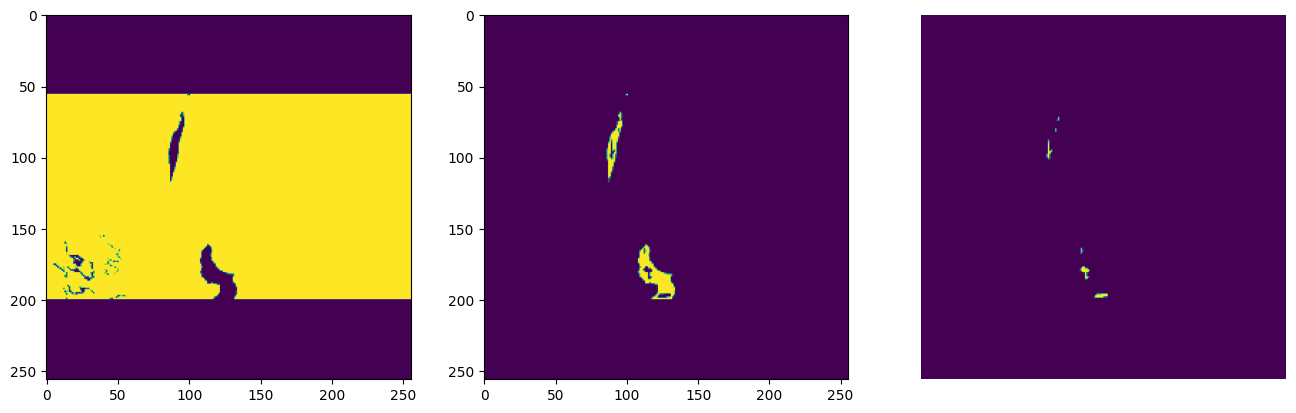

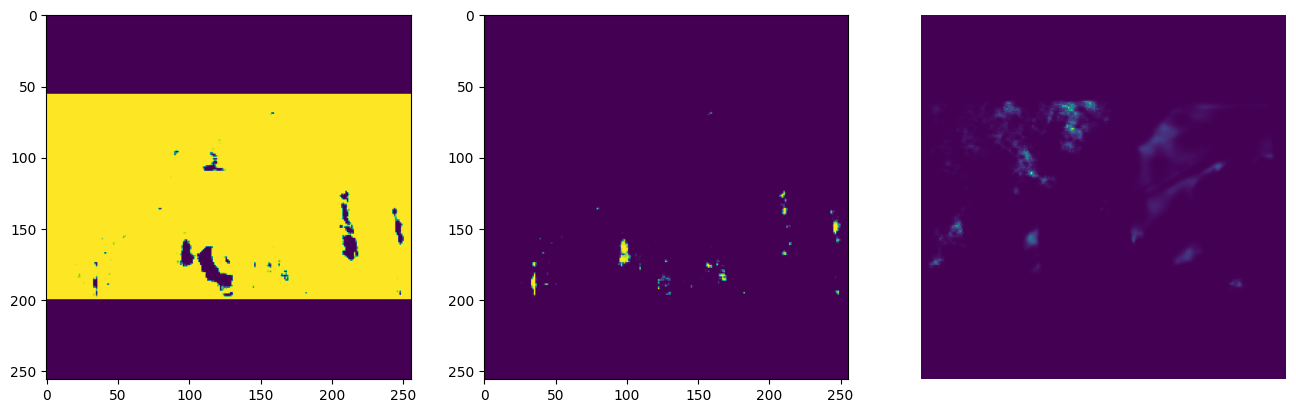

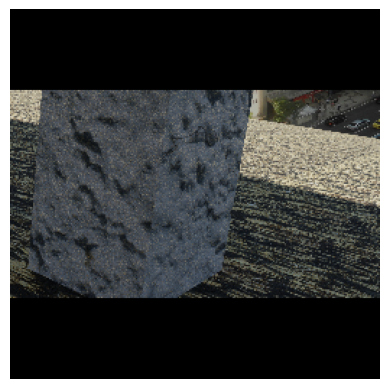

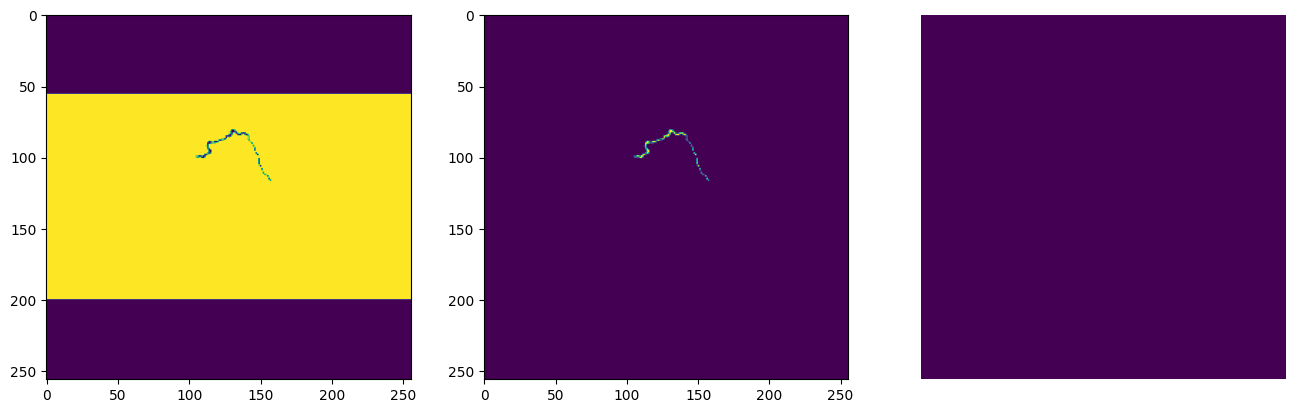

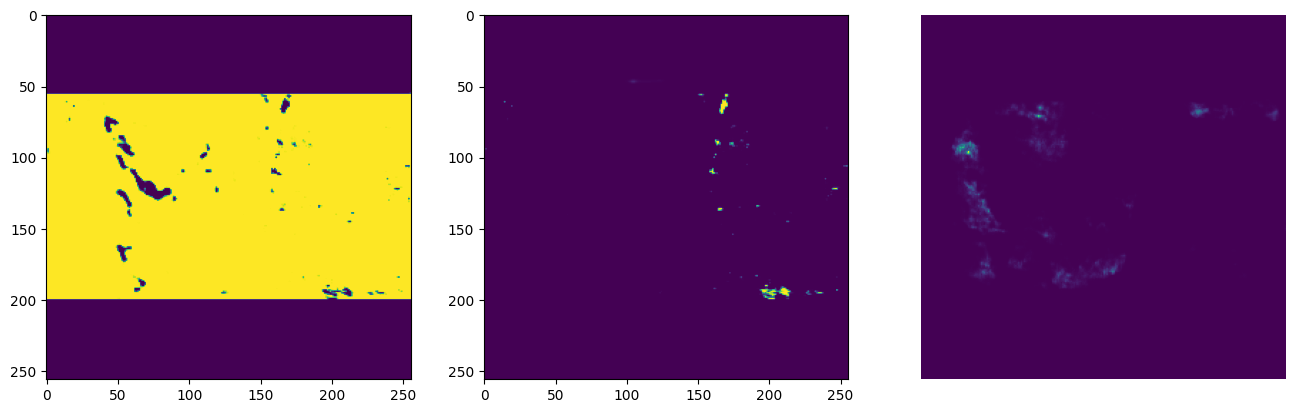

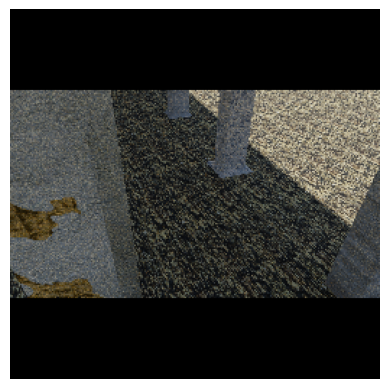

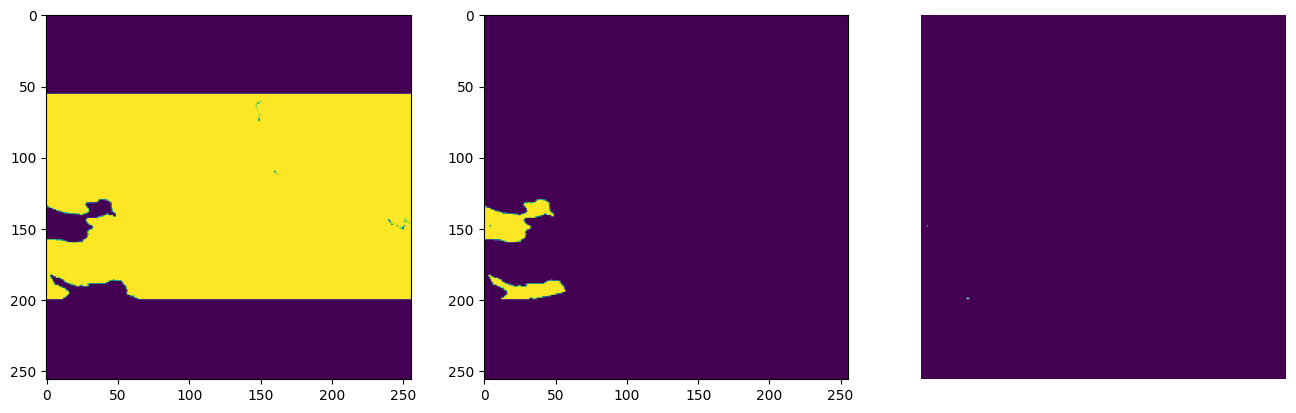

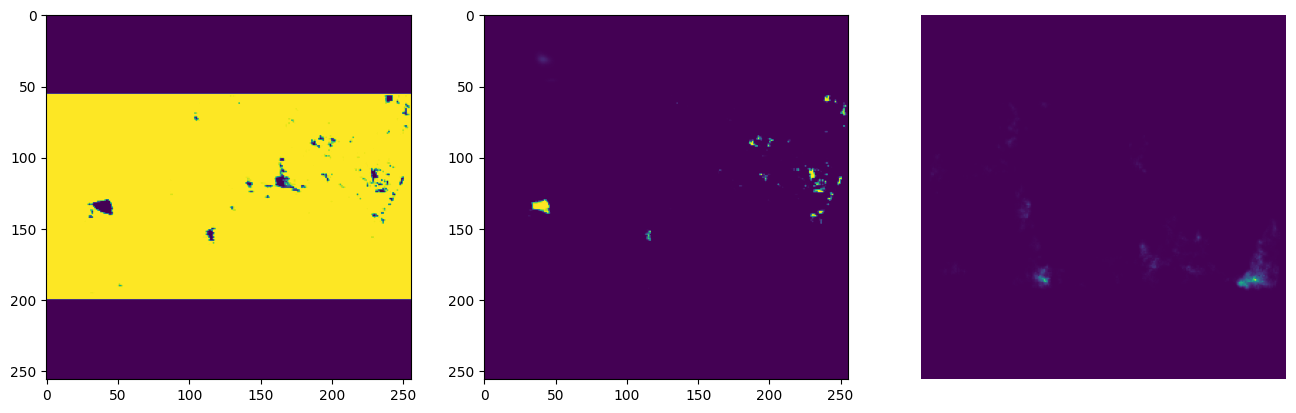

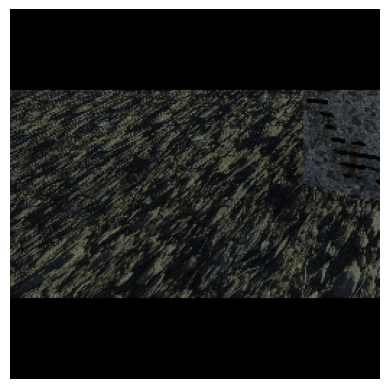

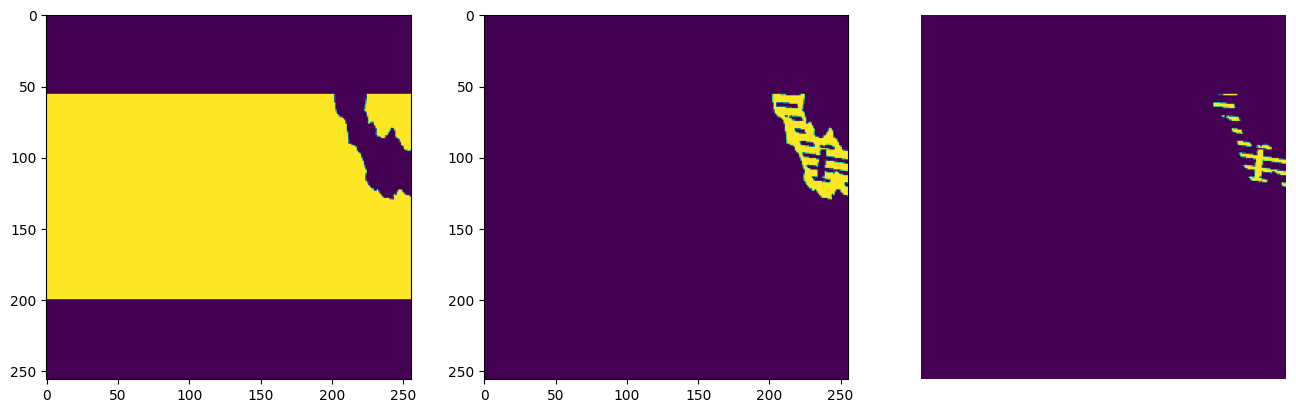

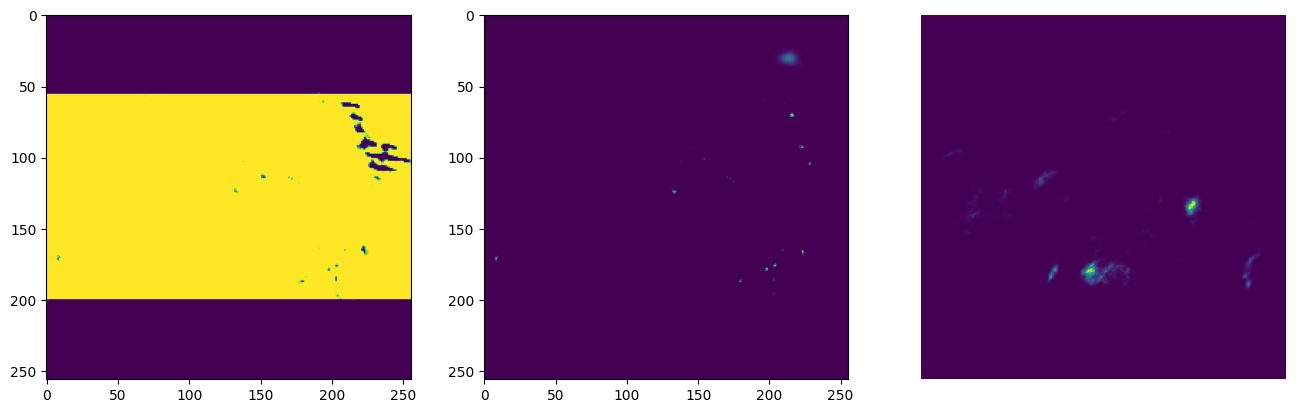

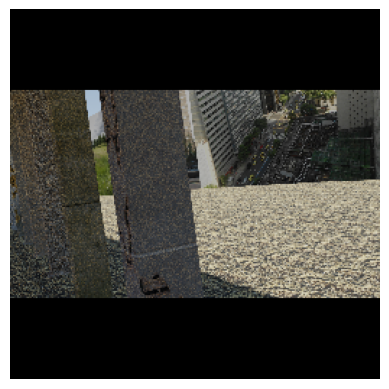

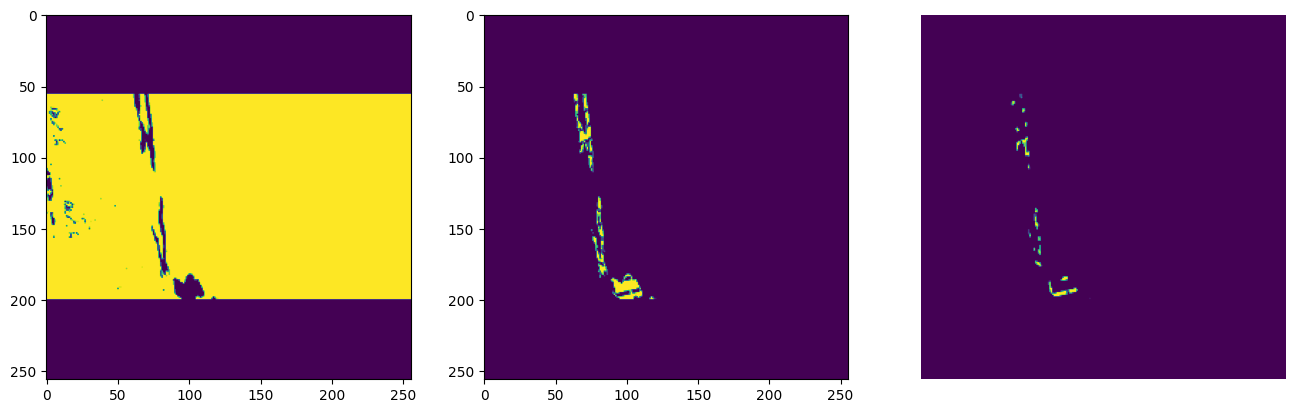

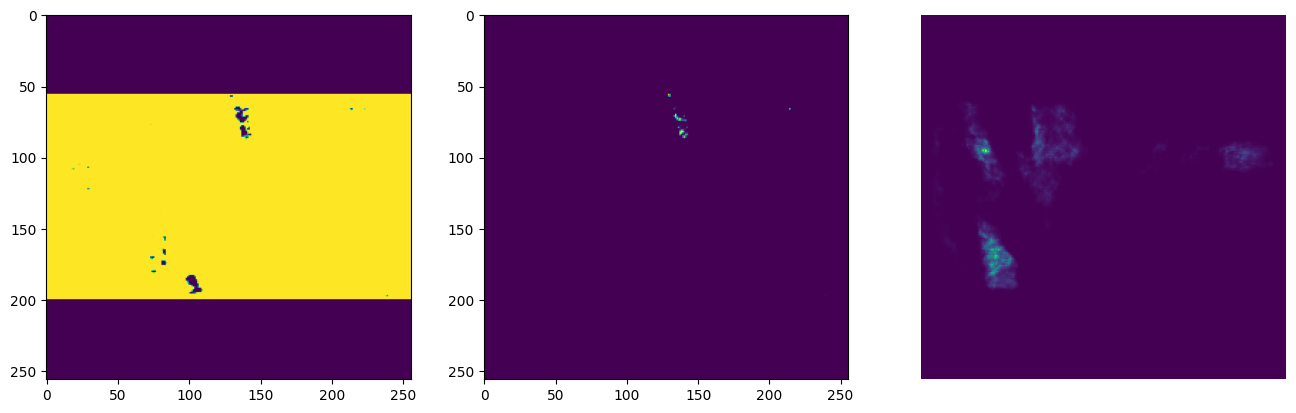

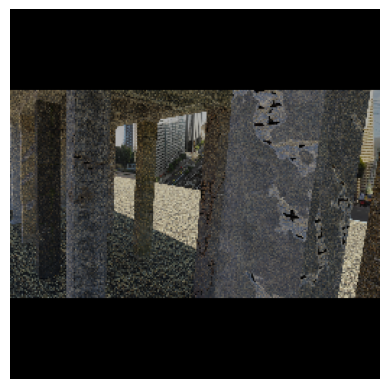

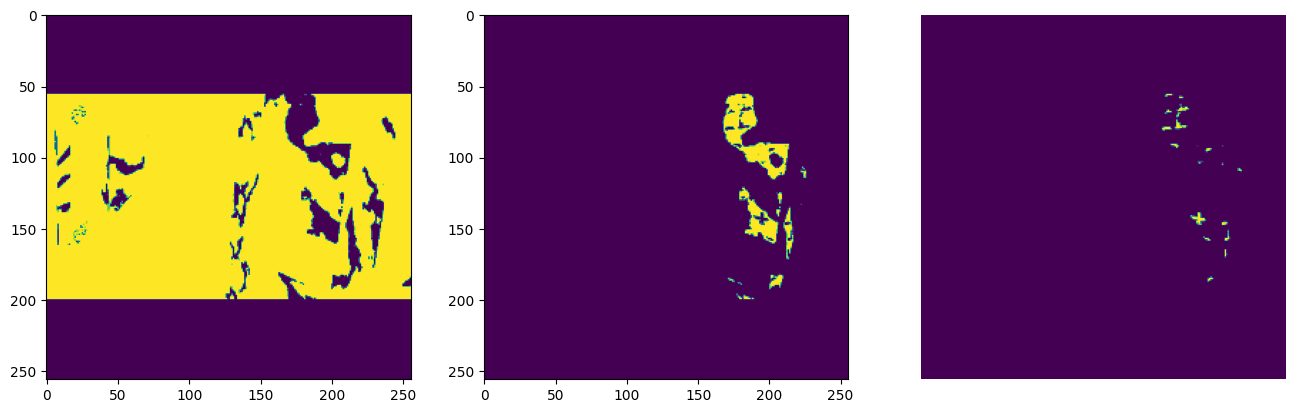

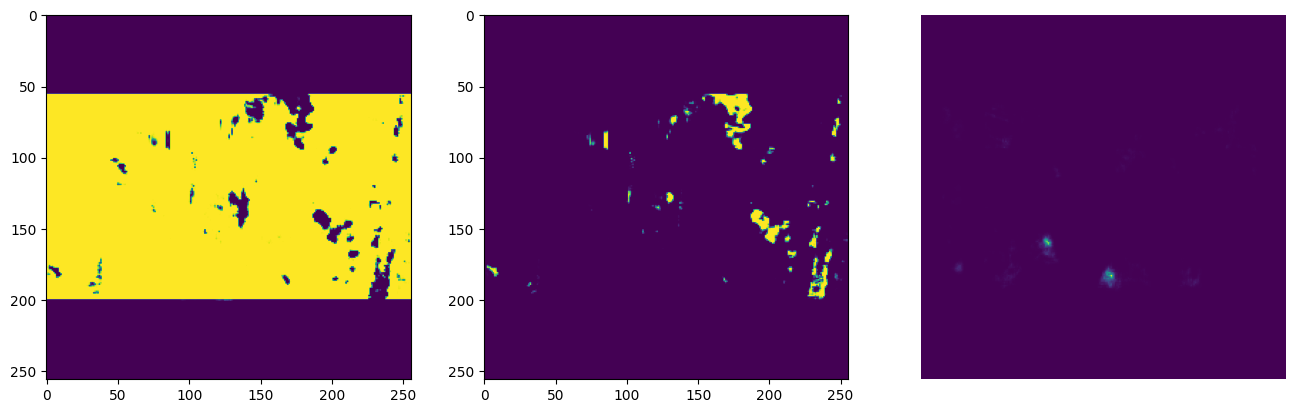

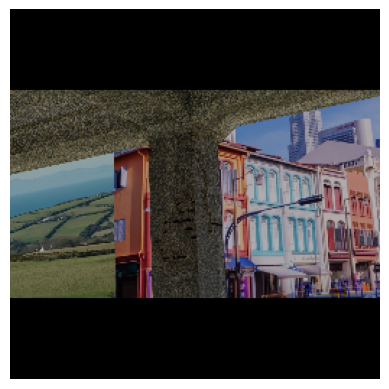

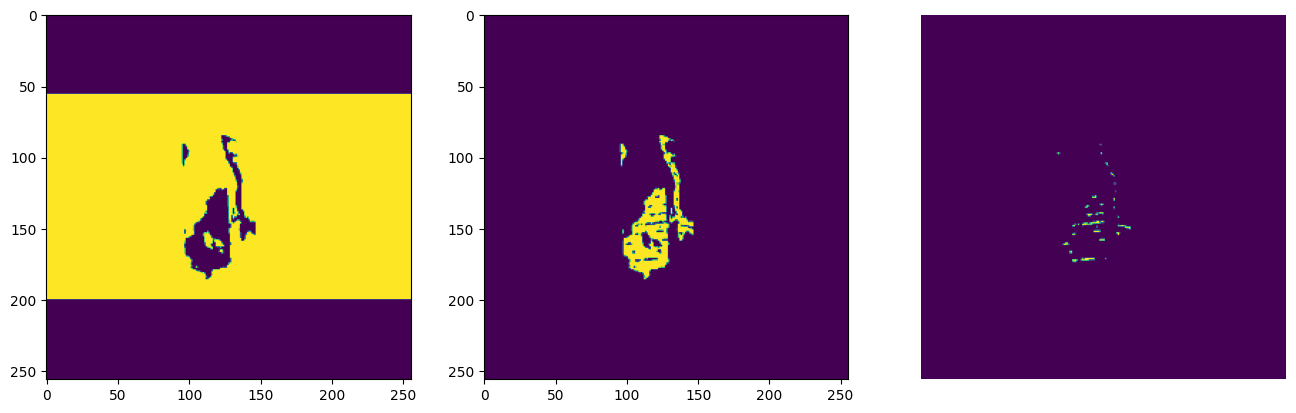

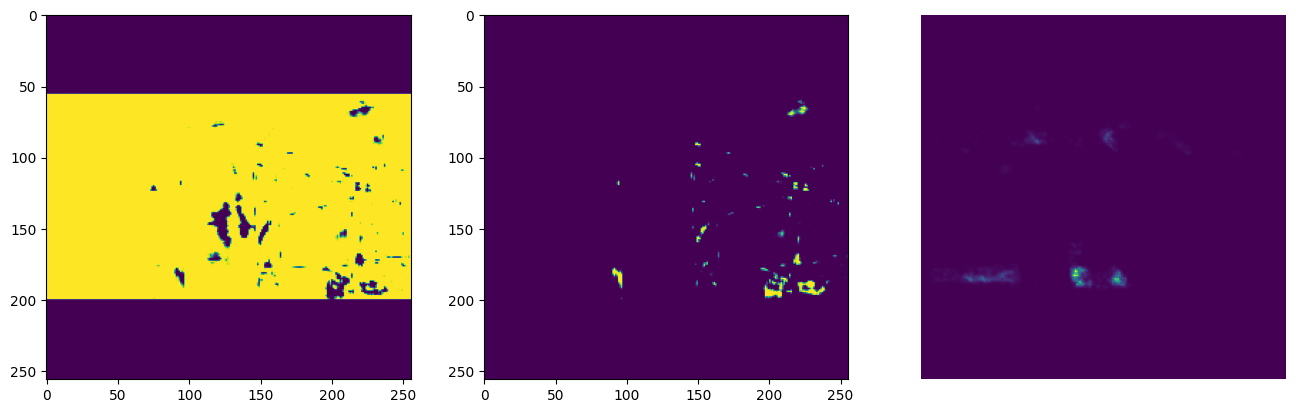

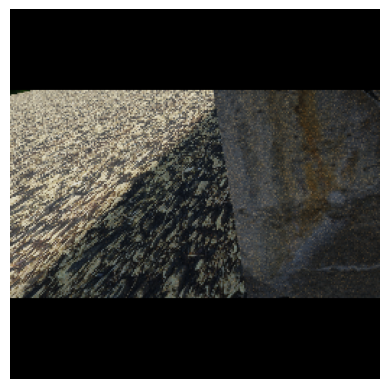

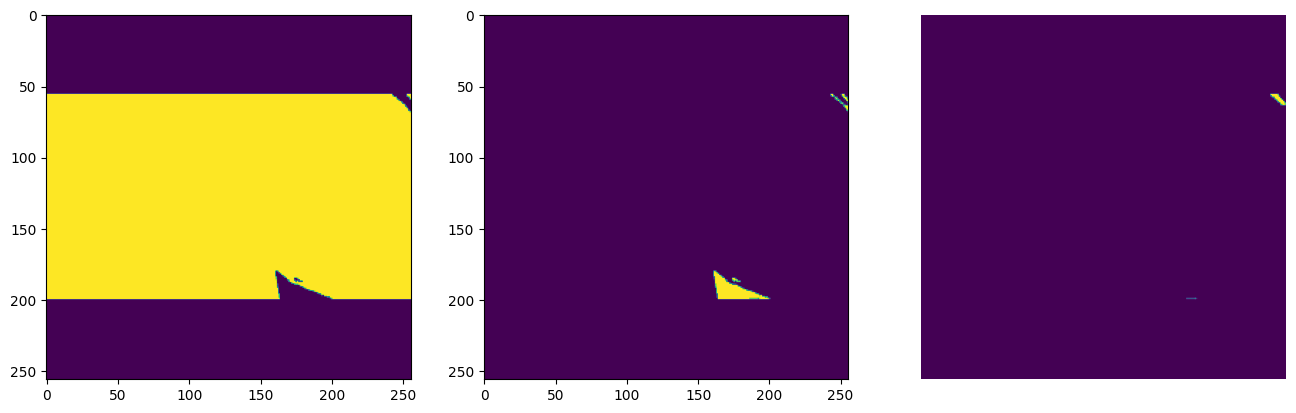

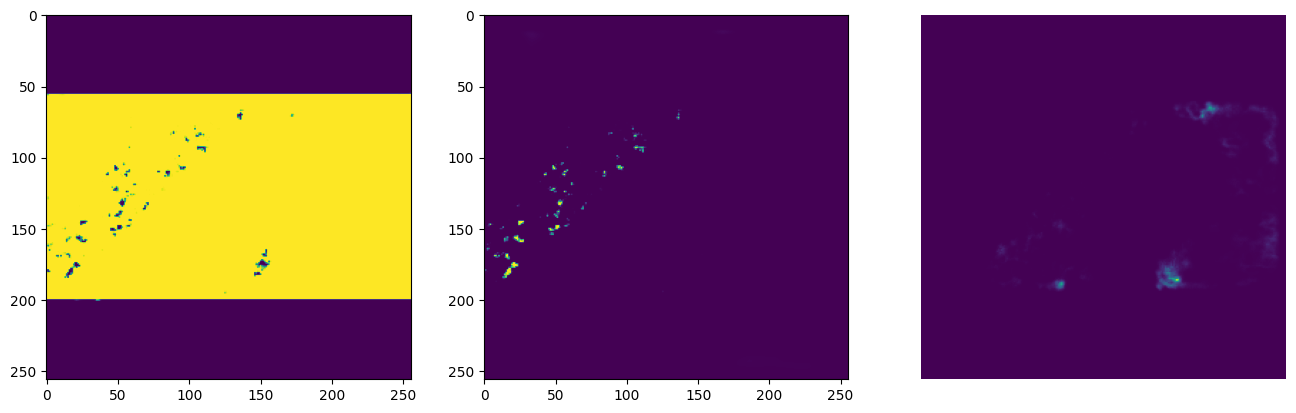

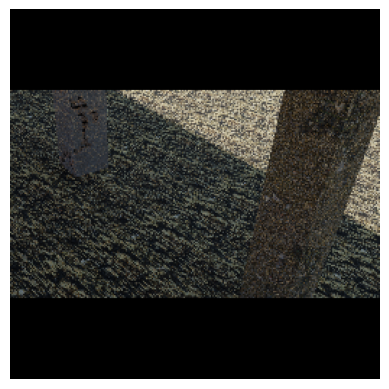

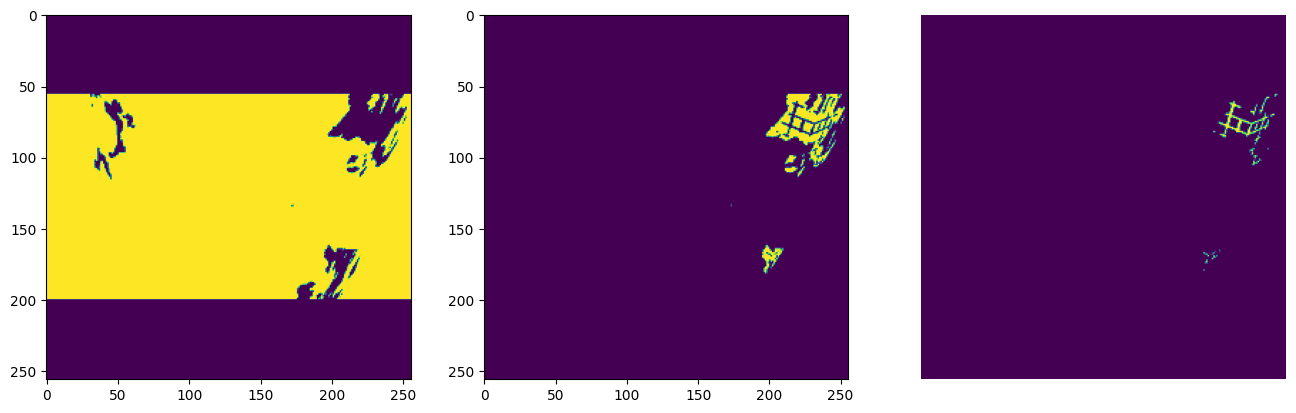

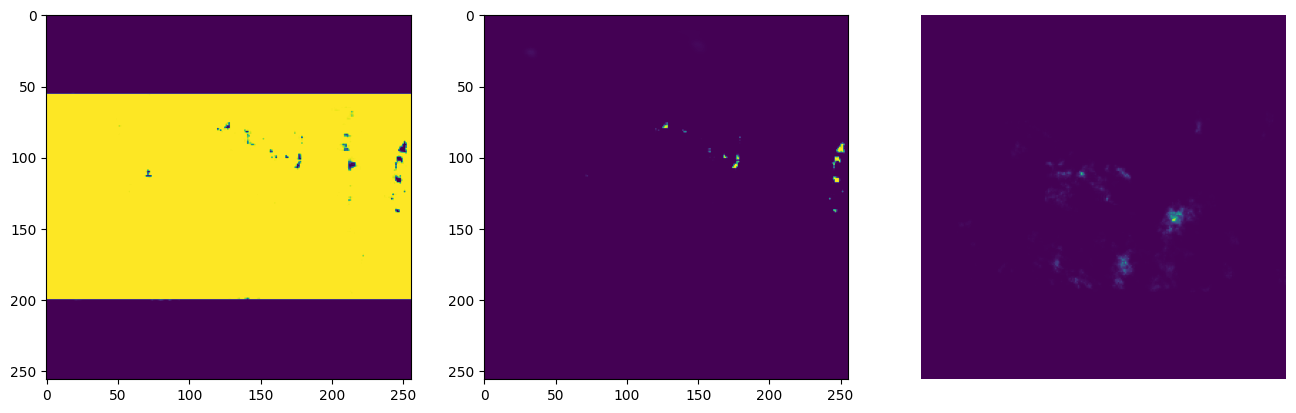

In [35]:
# Run the trained model on a few examples from the test set
for inp, tar in val_dataset.take(9):
  generate_images(generator, inp, tar)

In [36]:
#best results were obtained with binary cross entropy loss

generator.compile(optimizer= generator_optimizer,
              loss=  tf.keras.losses.BinaryCrossentropy(),
              metrics=[
                       tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(thresholds = 0.2),
                       tf.keras.metrics.Precision(thresholds = 0.7),
                       tf.keras.metrics.MeanIoU(3,name="iou")])


After 40 Epochs

In [ ]:
# Re-evaluate the model
loss, acc,_,_,_ = generator.evaluate(val_dataset, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

After 30 epoch

In [37]:
# Re-evaluate the model
loss, acc,_,_,_ = generator.evaluate(val_dataset, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

781/781 - 213s - loss: 1.6352 - binary_accuracy: 0.9738 - recall_1: 0.9235 - precision_1: 0.9576 - iou: 0.3353 - 213s/epoch - 273ms/step
Restored model, accuracy: 97.38%


After 10 epoch

In [31]:
# Re-evaluate the model
loss, acc,_,_,_ = generator.evaluate(val_dataset, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

781/781 - 268s - loss: 1.5449 - binary_accuracy: 0.9686 - recall: 0.9008 - precision: 0.9601 - iou: 0.3565 - 268s/epoch - 343ms/step
Restored model, accuracy: 96.86%


After 20 epoch

In [32]:
# Re-evaluate the model
loss, acc,_,_,_ = generator.evaluate(val_dataset, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

781/781 - 215s - loss: 1.6192 - binary_accuracy: 0.9738 - recall: 0.9171 - precision: 0.9635 - iou: 0.3363 - 215s/epoch - 275ms/step
Restored model, accuracy: 97.38%
